In [64]:
from gensim.models.doc2vec import LabeledSentence
from gensim.models.doc2vec import Doc2Vec
from gensim import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import seaborn as sns
sns.set()
%matplotlib inline

In [77]:
class File2DocSpace(Doc2Vec):
    
    def __init__(self, file_name, epochs=1, size=80,
                 window=3,
                 min_count=2, workers=1,
                 alpha=0.5, min_alpha=0.025, batch_words=30,
                 train= True):
    
        self.file_name = file_name
        self.D, self.y = self.load_data()
        self.epochs = epochs
        self.dim = size
        # for scatter plot matrix functionality
        self.hues = pd.Series(self.y).map(lambda x: "blue" if x is 0 else "green")
        super(File2DocSpace, self).__init__(self.D, size=80,
                                            window=3,
                                            min_count=2, workers=1,alpha=0.5,
                                            min_alpha=0.025, batch_words=30)
        if train:
            self.train2()
            self.X = np.asarray(self.docvecs)
            self.docvecs = None # for RAM efficiency
        else:
            self.X = None

    def load_data(self):
        """
        Places data in list of labelled sentences format which
        allows gensim to build vocab automatically
        """
        with open(self.file_name) as f:
            lines = f.readlines()

        labels = list()
        all_dat = list()
        for i, l in enumerate(lines):

            labels.append(int(l[0]))

            l = gensim.utils.any2unicode(l)
            all_dat.append(LabeledSentence(l.split("\t")[-1], [i]))

        return all_dat, np.asarray(labels)
    
    def visualize_vec_as_mat(self):
        """
         Draws a set of samples from pargraph vector space
         and visualizes as a matrix
        
        """
        r1 = randint(self.dim, len(self.D) -1 )
        if self.X is not None:
            matrix = self.X[r1-self.dim:r1, :]
        else:
            matrix = np.asarray(self.docvecs)[r1-self.dim:r1, :]
        plt.matshow(matrix)
    
    
    def visualize_scatter_plot_mat(self, dim=6):
        dictio = {}
        r1 = randint(dim, (self.dim) )
        for i in range(r1-dim, r1):
            if self.X is not None:
                dictio["dimension "+ str(i)] = self.X[:,i]
            else:
                dictio["dimension "+ str(i)] = np.asarray(self.docvecs)[:,i]
        dictio["hue"] = self.hues
        df = pd.DataFrame(dictio)
        sns.pairplot(df, hue="hue")
    
    def train2(self):
        """
        Neural network SGD like trainign for paragraph vector estimation
        """
        for epoch in range(self.epochs):
            print "epoch: ", epoch
            self.train(self.D)
            self.alpha -= 0.002  # decrease the learning rate
            self.min_alpha = model.alpha  # fix the learning rate, no decay

In [81]:
model = File2DocSpace("training_data.txt", epochs=10)

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9


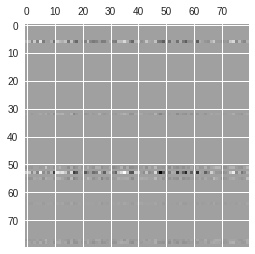

In [82]:
model.visualize_vec_as_mat()

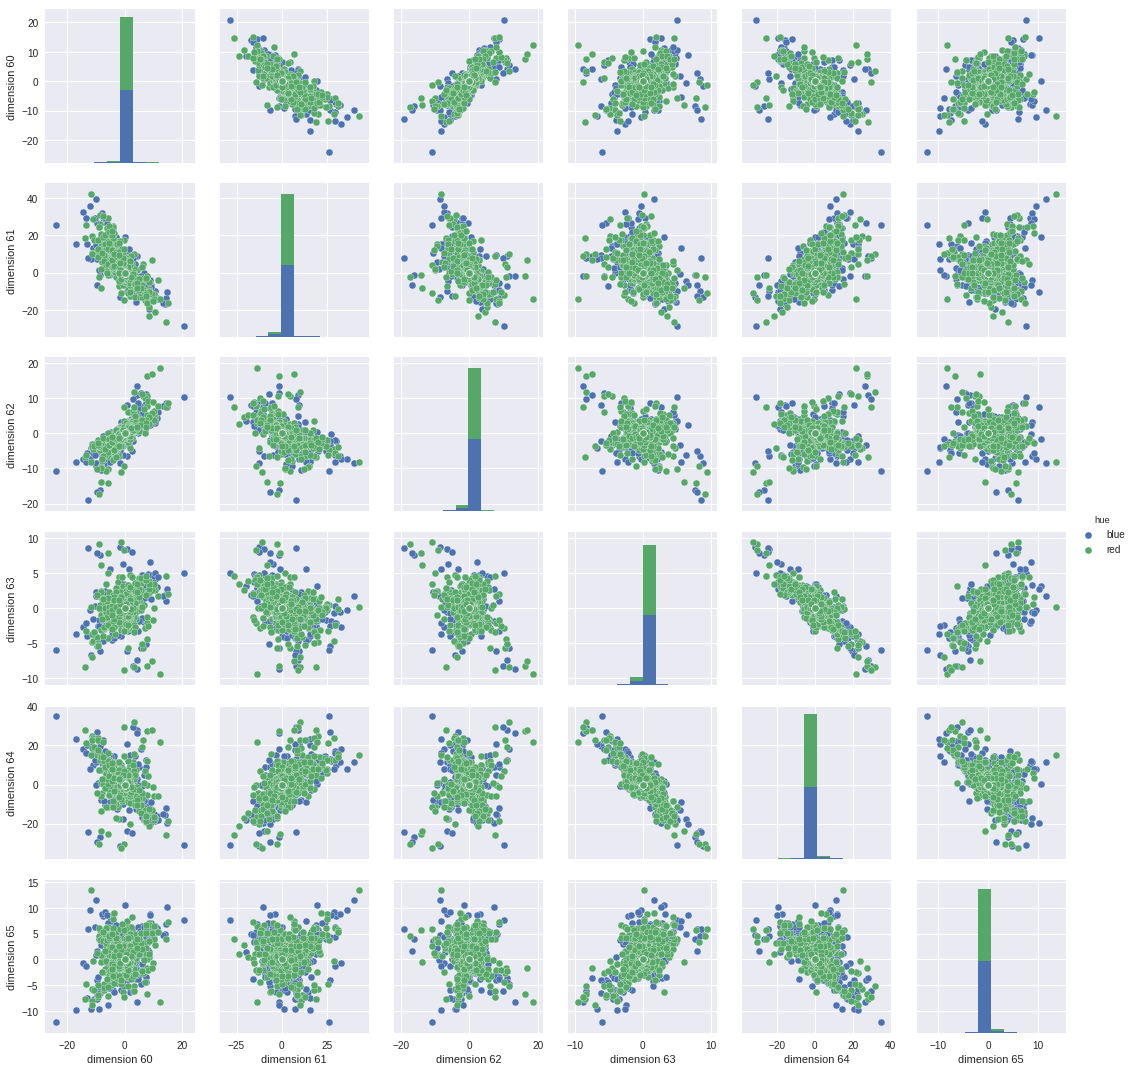

In [84]:
model.visualize_scatter_plot_mat()